### NUTS

This code runs MCMC to make sure the model logic is working independent of any SVI complexity. It should be run on a small subset of the data. 

In [1]:
from matplotlib import pyplot as plt
from numpyro.infer import MCMC, NUTS, init_to_value
from jax import numpy as jnp
import numpyro
numpyro.set_host_device_count(8)
import jax
import numpy as np

from numpyro.infer.util import log_density
from numpyro.infer import init_to_median, init_to_feasible

from tfscreen.analysis.hierarchical.growth_model import GrowthModel
#from tfscreen.analysis.hierarchical.growth_model.batch import sample_batch
import tfscreen

def run_nuts_diagnostic(gm,seed,num_warmup=500, num_samples=500, num_chains=1,target_accept_prob=0.9):
    """
    Run NUTS on a model. 
    """

    # Create seed
    main_key = jax.random.PRNGKey(seed)

    # Setup model
    jax_model_kwargs = {
        "priors": gm.priors,
        "data": gm.data 
    }

    # Let NumPyro try to find a valid init using its standard heuristic
    init_params, potential_fn, post_transform, _ = numpyro.infer.util.initialize_model(
        main_key,
        gm.jax_model,
        model_args=[],
        model_kwargs=jax_model_kwargs,
        init_strategy=init_to_median # safer than uniform for hierarchical
    )
    
    init_strategy = init_to_value(values=init_params)
    #init_strategy = init_to_value(values=gm.init_params)

    # Setup kernel
    kernel = NUTS(gm.jax_model, 
                  init_strategy=init_strategy,
                  target_accept_prob=target_accept_prob)

    # Setup mcmc
    mcmc = MCMC(kernel, 
                num_warmup=num_warmup, 
                num_samples=num_samples, 
                num_chains=num_chains,
                progress_bar=True)

    # Run sampler
    print("Starting NUTS run...", flush=True)
    run_key, main_key = jax.random.split(main_key)
    mcmc.run(run_key, **jax_model_kwargs)

    
    # Check for divergences (geometry failures)
    divergences = mcmc.get_extra_fields()['diverging']
    num_divergences =  jnp.sum(divergences)
    print(f"Number of divergences: {num_divergences}")
    
    return mcmc

to_get_list = ["wt","M42I","H74A","K84L","I64N","L45P","I79C","T68V","A81C"]

growth_df = tfscreen.util.read_dataframe("growth.csv")
growth_df_subset = growth_df[growth_df["genotype"].isin(to_get_list)].reset_index(drop=True)

bind_df = tfscreen.util.read_dataframe("binding.csv")
bind_df_subset = bind_df[bind_df["genotype"].isin(to_get_list)].reset_index(drop=True)

gm = GrowthModel(growth_df=growth_df_subset,
                 binding_df=bind_df_subset,
                 theta="hill",
                 condition_growth="hierarchical",
                 theta_binding_noise="none",
                 theta_growth_noise="none",
                 activity="horseshoe")

mcmc = run_nuts_diagnostic(gm,num_chains=1,seed=1242,num_warmup=500,num_samples=1000) 
posteriors = mcmc.get_samples()
params = gm.extract_parameters(posteriors)

Starting NUTS run...


sample: 100%|█| 1500/1500 [05:06<00:00,  4.89it/s, 1023 steps of size 5.90e-04. acc. pro


Number of divergences: 0


In [2]:
print(params.keys())
params["theta_high"]

dict_keys(['hill_n', 'log_hill_K', 'theta_high', 'theta_low', 'growth_m', 'growth_k', 'ln_cfu0', 'dk_geno', 'activity'])


,genotype,titrant_name,min,lower_95,lower_std,lower_quartile,median,upper_quartile,upper_std,upper_95,max
0,wt,iptg,0.136019,0.148183,0.163039,0.167752,0.176573,0.185651,0.190107,0.202914,0.221286
1,M42I,iptg,0.356341,0.408589,0.470187,0.481948,0.500271,0.512570,0.519185,0.535257,0.552378
2,L45P,iptg,0.000062,0.000145,0.000682,0.001219,0.002818,0.006140,0.007923,0.014897,0.026752
3,I64N,iptg,0.467345,0.566392,0.622707,0.627923,0.635228,0.642175,0.645124,0.652859,0.659737
4,T68V,iptg,0.004063,0.006905,0.013900,0.018332,0.026390,0.039788,0.051047,0.075148,0.097455
5,H74A,iptg,0.000018,0.000168,0.001007,0.001896,0.007707,0.021407,0.035016,0.088074,0.146013
6,I79C,iptg,0.008795,0.014783,0.029988,0.039764,0.069458,0.114521,0.137508,0.222005,0.277224
7,A81C,iptg,0.001247,0.010656,0.148001,0.173165,0.221257,0.272857,0.296243,0.353329,0.428924
8,K84L,iptg,0.000530,0.001253,0.002794,0.004805,0.015917,0.040981,0.050599,0.086888,0.121817


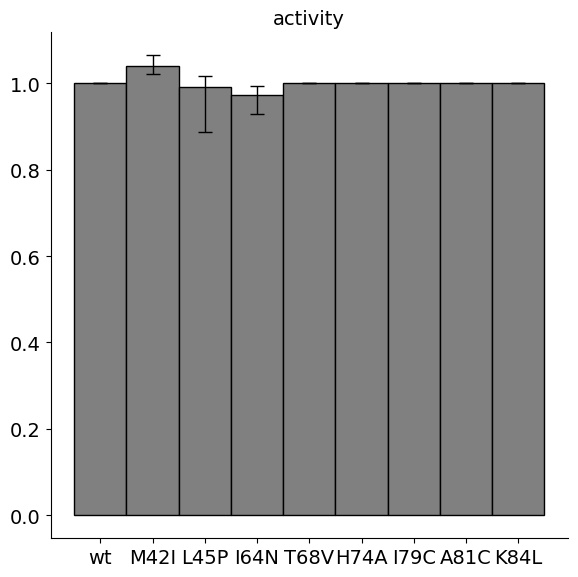

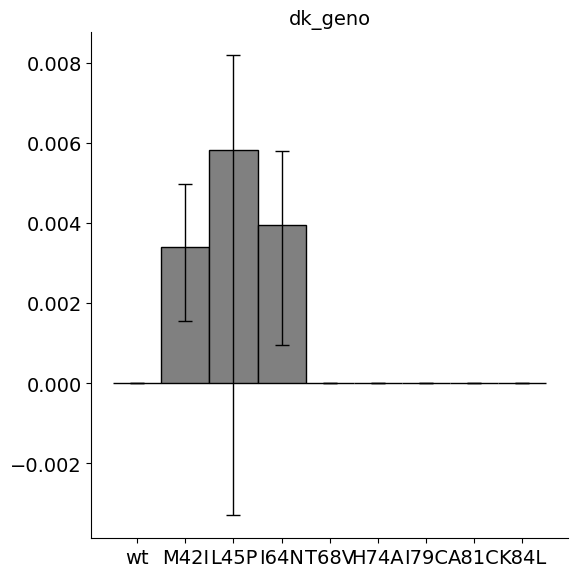

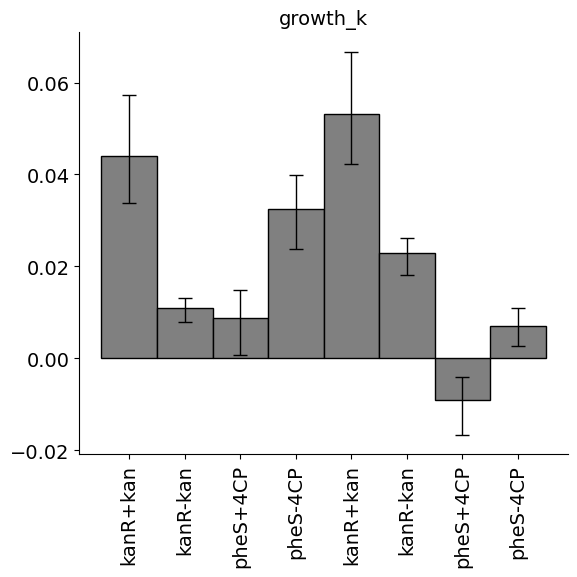

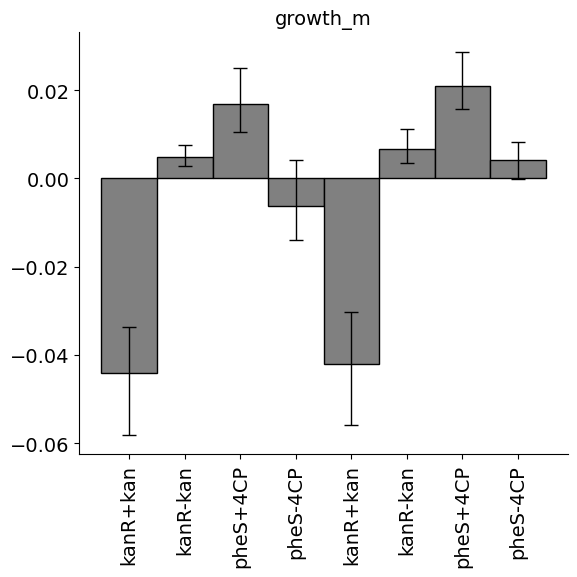

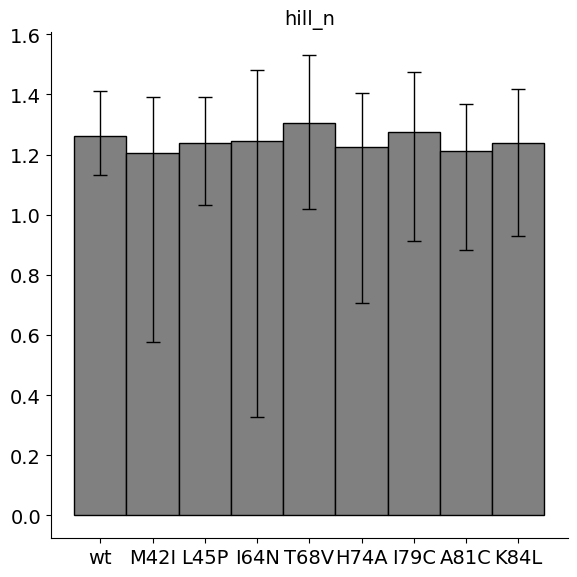

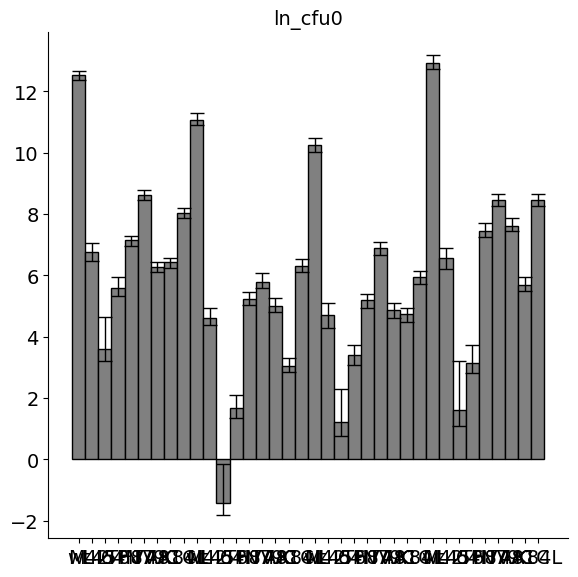

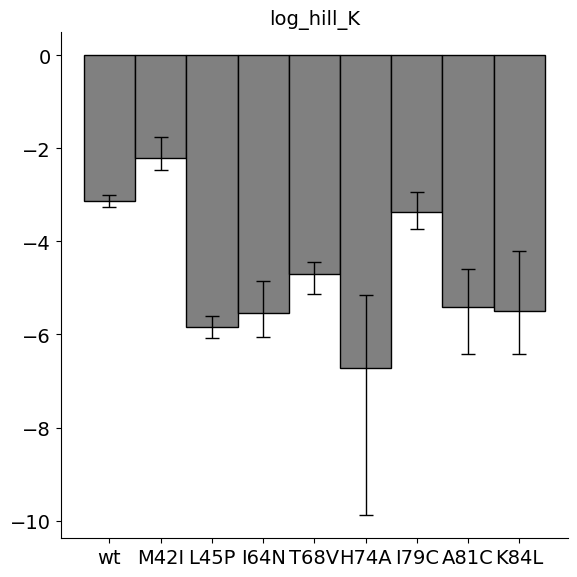

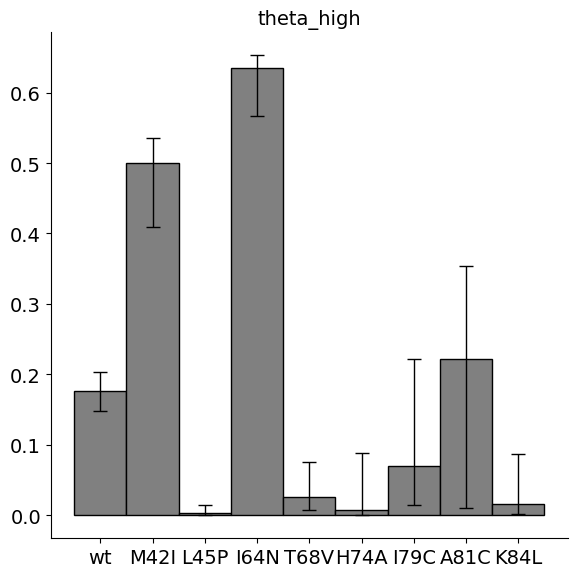

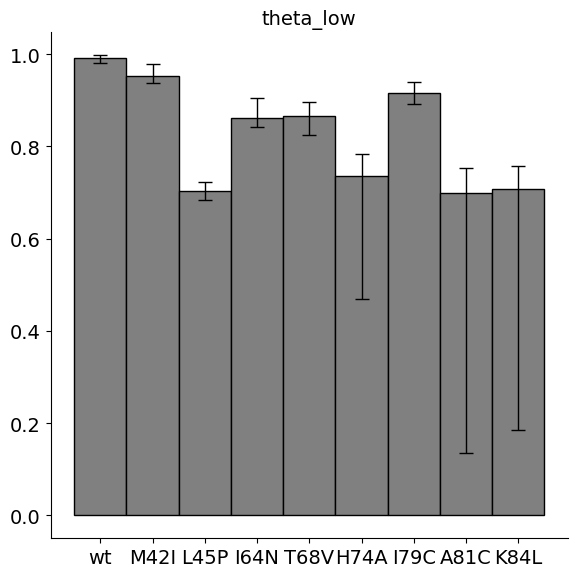

In [3]:
def plot_fit_param(df,title=None,ax=None):

    if ax is None:
        fig, ax = plt.subplots(1,figsize=(6,6))

    x = np.arange(len(df))
    y = df["median"]
    y_low_95 = y - df["lower_95"]
    y_low_std = y - df["lower_std"]
    y_high_std = df["upper_std"] - y
    y_high_95 = df["upper_95"] - y

    for i in range(len(x)):
        ax.fill([x[i],x[i],x[i]+1,x[i]+1],
                [0   ,y[i],y[i]  ,0],
                facecolor='gray',edgecolor='black')
    ax.errorbar(x=x+0.5,
                 y=y,
                 yerr=[y_low_95,y_high_95],
                 lw=0,
                 elinewidth=1,
                 capsize=5,
                 color='black')
    
    ax.set_xticks(x + 0.5)

    if "genotype" in df.columns:
        ax.set_xticklabels(df["genotype"])
    else:
        ax.set_xticklabels(df["condition"])
        ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(title)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    fig = ax.get_figure()
    fig.tight_layout()
        

    return fig, ax

param_keys = list(params.keys())
param_keys.sort()
for p in param_keys:

    fig, ax = plot_fit_param(params[p],p)

    
    